<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter15/Handwriting_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

--2024-01-30 16:22:11--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2024-01-30 16:22:12--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65beabed75c476a143e6a496e0.dl.dropboxusercontent.com/cd/0/inline/CMUb7sdJIqXXicLnQztFUXJfJcJSaLVQyj5nIDQhebx49vn7Y5-HlmBMGzsBBCVriuJ_2A9nYSkOocOwJDsScgx6klChReWmsrhNK9gRxXmc5Pd0oouq1t_zp9zE9ncQSFh9OhQcwQB9VeNrZX54M4NL/file# [following]
--2024-01-30 16:22:12--  https://uc65beabed75c476a143e6a496e0.dl.dropboxusercontent.com/cd/0/inline/CMUb7sdJIqXXicLnQztFUXJfJcJSaLVQyj5nIDQhebx49vn7Y5-HlmBMGzsBBCVriuJ_2A9nYSkOocOwJ

In [2]:
!pip install torch_snippets torch_summary editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 87.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 55.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.4 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=8b627dc928c85dba34779feb299b58b822e9a9bff0997eea3e173fadcca832ac
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstalli

In [3]:
from torch_snippets import *
from torchsummary import summary
import editdistance

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]
images = Glob('synthetic-data')

In [5]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
B,T,V = 64, 32, len(vocab) 
H,W = 32, 128 

In [28]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]
    def __getitem__(self, ix):
        item = self.items[ix]
#         print(item)
        image = cv2.imread(str(item), 0)
        label = fname2label(item)
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")
    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}


In [29]:
from sklearn.model_selection import train_test_split
trn_items, val_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=22)
trn_ds = OCRDataset(trn_items)
val_ds = OCRDataset(val_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

In [31]:
# next(iter(trn_dl))

In [32]:
# cv2.imread("synthetic-data/fast@PSgEdb.png")

In [33]:
Glob('synthetic-data')[0]

» synthetic-data/fast@PSgEdb.png

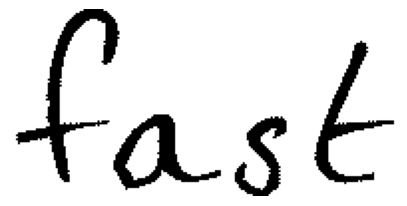

In [34]:
show(Glob('synthetic-data')[0])

In [35]:
from torch_snippets import Reshape, Permute
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [50]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [51]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [52]:
model = Ocr(len(vocab)).to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

In [53]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [54]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [55]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 50
log = Report(n_epochs)

In [ ]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, trn_loss=loss, trn_char_acc=ca, trn_word_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 6.000  trn_loss: 0.762  trn_char_acc: 0.842  val_word_acc: 0.489  val_loss: 0.578  trn_word_acc: 0.500  val_char_acc: 0.835  (171.97s - 1261.14s remaining)


Pred: `pay` :: Truth: `pay`

Pred: `move` :: Truth: `move`

Pred: `finre` :: Truth: `figure`

Pred: `sos` :: Truth: `save`

Pred: `prove` :: Truth: `prove`

EPOCH: 7.000  trn_loss: 0.617  trn_char_acc: 0.883  val_word_acc: 0.554  val_loss: 0.491  trn_word_acc: 0.596  val_char_acc: 0.861  (200.65s - 1232.59s remaining)


Pred: `lmdeer` :: Truth: `indeed`

Pred: `rofloct` :: Truth: `reflect`

Pred: `stay` :: Truth: `stay`

Pred: `consumer` :: Truth: `consumer`

Pred: `seruice` :: Truth: `service`

EPOCH: 8.000  trn_loss: 0.504  trn_char_acc: 0.910  val_word_acc: 0.628  val_loss: 0.395  trn_word_acc: 0.671  val_char_acc: 0.893  (229.32s - 1203.94s remaining)


Pred: `star` :: Truth: `star`

Pred: `but` :: Truth: `but`

Pred: `office` :: Truth: `office`

Pred: `above` :: Truth: `above`

Pred: `padig` :: Truth: `radio`

EPOCH: 9.000  trn_loss: 0.429  trn_char_acc: 0.929  val_word_acc: 0.653  val_loss: 0.359  trn_word_acc: 0.731  val_char_acc: 0.898  (257.62s - 1173.61s remaining)


Pred: `tree` :: Truth: `tree`

Pred: `manager` :: Truth: `manager`

Pred: `fire` :: Truth: `fire`

Pred: `skill` :: Truth: `skill`

Pred: `carry` :: Truth: `carry`

EPOCH: 10.000  trn_loss: 0.366  trn_char_acc: 0.943  val_word_acc: 0.685  val_loss: 0.317  trn_word_acc: 0.773  val_char_acc: 0.910  (285.90s - 1143.60s remaining)


Pred: `contain` :: Truth: `contain`

Pred: `hapen` :: Truth: `happen`

Pred: `never` :: Truth: `never`

Pred: `try` :: Truth: `try`

Pred: `hour` :: Truth: `hour`

EPOCH: 11.000  trn_loss: 0.320  trn_char_acc: 0.953  val_word_acc: 0.706  val_loss: 0.285  trn_word_acc: 0.809  val_char_acc: 0.921  (314.10s - 1113.61s remaining)


Pred: `tean` :: Truth: `team`

Pred: `paper` :: Truth: `paper`

Pred: `where` :: Truth: `where`

Pred: `sign` :: Truth: `sign`

Pred: `mission` :: Truth: `mission`

EPOCH: 12.000  trn_loss: 0.275  trn_char_acc: 0.962  val_word_acc: 0.730  val_loss: 0.266  trn_word_acc: 0.840  val_char_acc: 0.925  (342.44s - 1084.38s remaining)


Pred: `have` :: Truth: `have`

Pred: `minute` :: Truth: `minute`

Pred: `she` :: Truth: `she`

Pred: `over` :: Truth: `over`

Pred: `mayre` :: Truth: `maybe`

EPOCH: 13.000  trn_loss: 0.246  trn_char_acc: 0.968  val_word_acc: 0.754  val_loss: 0.238  trn_word_acc: 0.861  val_char_acc: 0.934  (370.82s - 1055.42s remaining)


Pred: `necessary` :: Truth: `necessary`

Pred: `red` :: Truth: `red`

Pred: `true` :: Truth: `true`

Pred: `every` :: Truth: `every`

Pred: `see` :: Truth: `see`

EPOCH: 14.000  trn_loss: 0.226  trn_char_acc: 0.972  val_word_acc: 0.759  val_loss: 0.228  trn_word_acc: 0.875  val_char_acc: 0.936  (399.25s - 1026.64s remaining)


Pred: `large` :: Truth: `large`

Pred: `particularly` :: Truth: `particularly`

Pred: `behavior` :: Truth: `behavior`

Pred: `sing` :: Truth: `sing`

Pred: `take` :: Truth: `take`

EPOCH: 15.000  trn_loss: 0.205  trn_char_acc: 0.976  val_word_acc: 0.769  val_loss: 0.222  trn_word_acc: 0.891  val_char_acc: 0.938  (428.06s - 998.80s remaining)


Pred: `partner` :: Truth: `partner`

Pred: `position` :: Truth: `position`

Pred: `fil` :: Truth: `fill`

Pred: `whether` :: Truth: `whether`

Pred: `seen` :: Truth: `seem`

EPOCH: 16.000  trn_loss: 0.184  trn_char_acc: 0.979  val_word_acc: 0.786  val_loss: 0.207  trn_word_acc: 0.905  val_char_acc: 0.943  (457.18s - 971.50s remaining)


Pred: `grime` :: Truth: `crime`

Pred: `section` :: Truth: `section`

Pred: `trade` :: Truth: `trade`

Pred: `phone` :: Truth: `phone`

Pred: `though` :: Truth: `though`

EPOCH: 17.000  trn_loss: 0.171  trn_char_acc: 0.982  val_word_acc: 0.793  val_loss: 0.200  trn_word_acc: 0.918  val_char_acc: 0.944  (485.57s - 942.58s remaining)


Pred: `head` :: Truth: `head`

Pred: `under` :: Truth: `under`

Pred: `suport` :: Truth: `support`

Pred: `result` :: Truth: `result`

Pred: `partinany` :: Truth: `particularly`

EPOCH: 18.000  trn_loss: 0.156  trn_char_acc: 0.984  val_word_acc: 0.797  val_loss: 0.198  trn_word_acc: 0.925  val_char_acc: 0.945  (514.21s - 914.14s remaining)


Pred: `never` :: Truth: `never`

Pred: `wall` :: Truth: `wall`

Pred: `writer` :: Truth: `writer`

Pred: `not` :: Truth: `not`

Pred: `nothing` :: Truth: `nothing`

EPOCH: 19.000  trn_loss: 0.145  trn_char_acc: 0.986  val_word_acc: 0.809  val_loss: 0.186  trn_word_acc: 0.934  val_char_acc: 0.949  (542.55s - 885.21s remaining)


Pred: `cary` :: Truth: `carry`

Pred: `training` :: Truth: `training`

Pred: `main` :: Truth: `main`

Pred: `capital` :: Truth: `capital`

Pred: `compare` :: Truth: `compare`

EPOCH: 20.000  trn_loss: 0.143  trn_char_acc: 0.987  val_word_acc: 0.803  val_loss: 0.184  trn_word_acc: 0.938  val_char_acc: 0.949  (571.01s - 856.52s remaining)


Pred: `health` :: Truth: `health`

Pred: `real` :: Truth: `real`

Pred: `guy` :: Truth: `guy`

Pred: `back` :: Truth: `back`

Pred: `serious` :: Truth: `serious`

EPOCH: 21.000  trn_loss: 0.127  trn_char_acc: 0.988  val_word_acc: 0.816  val_loss: 0.175  trn_word_acc: 0.943  val_char_acc: 0.949  (599.26s - 827.55s remaining)


Pred: `avt` :: Truth: `art`

Pred: `clue` :: Truth: `else`

Pred: `method` :: Truth: `method`

Pred: `actually` :: Truth: `actually`

Pred: `athougn` :: Truth: `although`

EPOCH: 22.000  trn_loss: 0.121  trn_char_acc: 0.990  val_word_acc: 0.811  val_loss: 0.174  trn_word_acc: 0.949  val_char_acc: 0.950  (627.47s - 798.59s remaining)


Pred: `hinself` :: Truth: `himself`

Pred: `close` :: Truth: `close`

Pred: `kid` :: Truth: `kid`

Pred: `middle` :: Truth: `middle`

Pred: `detail` :: Truth: `detail`

EPOCH: 23.000  trn_loss: 0.114  trn_char_acc: 0.991  val_word_acc: 0.823  val_loss: 0.165  trn_word_acc: 0.954  val_char_acc: 0.954  (655.72s - 769.76s remaining)


Pred: `traditional` :: Truth: `traditional`

Pred: `seem` :: Truth: `seem`

Pred: `general` :: Truth: `general`

Pred: `painting` :: Truth: `painting`

Pred: `pustine` :: Truth: `picture`

EPOCH: 24.000  trn_loss: 0.105  trn_char_acc: 0.992  val_word_acc: 0.829  val_loss: 0.165  trn_word_acc: 0.959  val_char_acc: 0.955  (683.90s - 740.90s remaining)


Pred: `right` :: Truth: `right`

Pred: `benefit` :: Truth: `benefit`

Pred: `sort` :: Truth: `sort`

Pred: `offer` :: Truth: `offer`

Pred: `term` :: Truth: `term`

EPOCH: 25.000  trn_loss: 0.098  trn_char_acc: 0.993  val_word_acc: 0.823  val_loss: 0.167  trn_word_acc: 0.963  val_char_acc: 0.955  (712.16s - 712.16s remaining)


Pred: `son` :: Truth: `soon`

Pred: `biy` :: Truth: `buy`

Pred: `firom` :: Truth: `from`

Pred: `range` :: Truth: `range`

Pred: `tell` :: Truth: `tell`

EPOCH: 26.000  trn_loss: 0.094  trn_char_acc: 0.993  val_word_acc: 0.839  val_loss: 0.157  trn_word_acc: 0.964  val_char_acc: 0.957  (740.44s - 683.48s remaining)


Pred: `every` :: Truth: `every`

Pred: `show` :: Truth: `show`

Pred: `hot` :: Truth: `hot`

Pred: `town` :: Truth: `town`

Pred: `before` :: Truth: `before`

EPOCH: 26.048  trn_loss: 0.138  trn_char_acc: 0.993  trn_word_acc: 0.984  (741.61s - 681.94s remaining)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH: 35.000  trn_loss: 0.064  trn_char_acc: 0.997  val_word_acc: 0.859  val_loss: 0.135  trn_word_acc: 0.981  val_char_acc: 0.964  (993.90s - 425.96s remaining)


Pred: `usually` :: Truth: `usually`

Pred: `often` :: Truth: `often`

Pred: `return` :: Truth: `return`

Pred: `hope` :: Truth: `hope`

Pred: `community` :: Truth: `community`

EPOCH: 36.000  trn_loss: 0.063  trn_char_acc: 0.997  val_word_acc: 0.853  val_loss: 0.141  trn_word_acc: 0.981  val_char_acc: 0.963  (1022.05s - 397.46s remaining)


Pred: `religius` :: Truth: `religious`

Pred: `bank` :: Truth: `bank`

Pred: `detail` :: Truth: `detail`

Pred: `executive` :: Truth: `executive`

Pred: `service` :: Truth: `service`

EPOCH: 37.000  trn_loss: 0.059  trn_char_acc: 0.997  val_word_acc: 0.849  val_loss: 0.153  trn_word_acc: 0.985  val_char_acc: 0.960  (1050.13s - 368.96s remaining)


Pred: `moment` :: Truth: `moment`

Pred: `vote` :: Truth: `vote`

Pred: `produce` :: Truth: `produce`

Pred: `environmental` :: Truth: `environmental`

Pred: `language` :: Truth: `language`

EPOCH: 38.000  trn_loss: 0.065  trn_char_acc: 0.997  val_word_acc: 0.857  val_loss: 0.141  trn_word_acc: 0.983  val_char_acc: 0.962  (1078.29s - 340.51s remaining)


Pred: `style` :: Truth: `style`

Pred: `pccur` :: Truth: `occur`

Pred: `athorigon` :: Truth: `although`

Pred: `firm` :: Truth: `firm`

Pred: `business` :: Truth: `business`

EPOCH: 39.000  trn_loss: 0.058  trn_char_acc: 0.997  val_word_acc: 0.860  val_loss: 0.141  trn_word_acc: 0.984  val_char_acc: 0.964  (1106.37s - 312.05s remaining)


Pred: `myself` :: Truth: `myself`

Pred: `themselves` :: Truth: `themselves`

Pred: `someone` :: Truth: `someone`

Pred: `the` :: Truth: `the`

Pred: `least` :: Truth: `least`

EPOCH: 40.000  trn_loss: 0.057  trn_char_acc: 0.998  val_word_acc: 0.855  val_loss: 0.144  trn_word_acc: 0.986  val_char_acc: 0.963  (1134.51s - 283.63s remaining)


Pred: `believe` :: Truth: `believe`

Pred: `smile` :: Truth: `smile`

Pred: `gas` :: Truth: `gas`

Pred: `soldicr` :: Truth: `soldier`

Pred: `sure` :: Truth: `sure`

EPOCH: 41.000  trn_loss: 0.053  trn_char_acc: 0.997  val_word_acc: 0.855  val_loss: 0.149  trn_word_acc: 0.985  val_char_acc: 0.962  (1162.51s - 255.19s remaining)


Pred: `amount` :: Truth: `amount`

Pred: `may` :: Truth: `may`

Pred: `money` :: Truth: `money`

Pred: `box` :: Truth: `box`

Pred: `attorneny` :: Truth: `attorney`

EPOCH: 41.564  trn_loss: 0.123  trn_char_acc: 0.997  trn_word_acc: 0.984  (1175.78s - 238.65s remaining)

In [ ]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')

In [ ]:
print('hello')